# Life Pattern Report

The task is to generate a life pattern report for a user, which includes several useful information ranging from simple statistics to recommendations to improve the user’s life.

If you are running this on Google Colab, then since the storage isn't persistent, you will have to redownload the data whenever we start a new runtime. 

I went ahead and hosted it all on GitHub, you can view it [here](https://github.com/tsainez/lifelogging). 

## Data analysis

All data used in this project is stored in the `csv` directory.

```
┌── preprocessing_visualization.ipynb
├── classification.ipynb
├── life_pattern_report.ipynb
└── csv
    ├── device_uplink.csv
    ├── user_information.csv
    └── user_action_annotation
        ├── 230.csv
        ├── ...
        └── 676.csv
```

In [2]:
!git clone https://github.com/tsainez/lifelogging.git

fatal: destination path 'lifelogging' already exists and is not an empty directory.


I got rid of some of the user data because it was invalid or was irreparably corrupted.
- I chose not to use `499b.csv` because I wasn't sure what the data was or if I should just append it or not, and `499.csv` already seemed to have a good amount of data anyway.
- `507.csv` and `520.csv` seemed to contain the old `device_uplink`
  - While `507b.csv` did contain the data I was looking for, many of it's `start` and `end` values completley corrupted, showing only "`##########`"
    - Same for `536b.csv` and `634.csv`
- `530b.csv`, `545.csv`, `656.csv`, `669.csv`, `676.csv`, `512b.csv`, `635.csv`, and `655b.csv` are omitted for having too few entries in the data. The criteria for this was that the files had less than 100 entries.
  - The reasoning is that it might skew our models. For example, file `676.csv` only had 5 rows of data labeled. Also, some of these files did not even have enough rows to account for even one day, so the data would be useless anyway. 
- `230.csv` and `230b.csv` contain identical information; same for `514.csv` and `514b.csv`; and for `574.csv` and `574b.csv`. In order to not overrepresent this data, I chose to remove the `b` counterparts to each dataset. 
- `478.csv`, `495.csv`, `496.csv`, `506.csv`, `514.csv`, and `524.csv` were removed because they did not have a depression score in the old user information dataset. The depression score was needed in order to make a health score, so I could not use these files.

In [3]:
import pandas as pd
import numpy as np
import os 
import re

path = "csv/user_action_annotation/"
files = [f for f in os.listdir(path) if f.endswith('.csv')]

data = pd.DataFrame()
duplicates = pd.DataFrame(columns = ['num'])

for file in files:
    id = re.findall(r'\d+', file)
    temp = pd.read_csv(path + file)
    temp['id'] = id[0]
    duplicates.loc[id[0]] = temp.duplicated().size
    data = pd.concat([data, temp])

# Normalize all columns to ensure data integrity. 
data['start'] = pd.to_datetime(data['start'])
data['end'] = pd.to_datetime(data['end'])
data['labelName'] = data['labelName'].str.upper()
data['labelName'] = data['labelName'].astype('category')
data['id'] = pd.to_numeric(data['id'])

data

,start,end,labelName,id
0,2020-11-01 11:00:00,2020-11-01 11:30:00,COOK,551
1,2020-11-01 11:30:00,2020-11-01 12:00:00,EAT,551
2,2020-11-01 13:00:00,2020-11-01 13:30:00,COOK,551
3,2020-11-01 13:30:00,2020-11-01 14:00:00,COOK,551
4,2020-11-01 14:00:00,2020-11-01 14:30:00,EAT,551
...,...,...,...,...
4276,2021-03-11 15:30:00,2021-03-11 16:00:00,SLEEP,574
4277,2021-03-11 15:30:00,2021-03-11 16:00:00,SLEEP,574
4278,2021-03-11 15:30:00,2021-03-11 16:00:00,SLEEP,574
4279,2021-03-11 16:00:00,2021-03-11 16:30:00,SLEEP,574


There were a huge amount of duplicates in the data. Here's a bar graph that shows how many duplicates there were per user. 

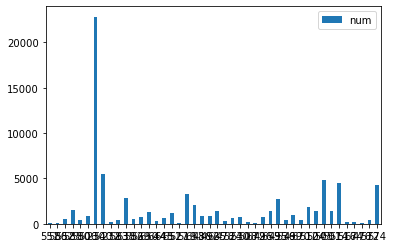

In [4]:
import matplotlib.pyplot as plt
# %matplotlib inline

duplicates.plot.bar(y='num', rot=0)
plt.show()

As you can see, most of the files had errors, with one having more than 20,000 duplicated entries. It's not entirely clear how most of these files ended up with so many duplicated rows— nonetheless, they are removed from the total dataset.

In [5]:
data = data.drop_duplicates()
data

,start,end,labelName,id
0,2020-11-01 11:00:00,2020-11-01 11:30:00,COOK,551
1,2020-11-01 11:30:00,2020-11-01 12:00:00,EAT,551
2,2020-11-01 13:00:00,2020-11-01 13:30:00,COOK,551
3,2020-11-01 13:30:00,2020-11-01 14:00:00,COOK,551
4,2020-11-01 14:00:00,2020-11-01 14:30:00,EAT,551
...,...,...,...,...
4249,2021-03-11 14:00:00,2021-03-11 14:30:00,GO WALK,574
4259,2021-03-11 15:00:00,2021-03-11 15:30:00,GO WALK,574
4270,2021-03-11 15:00:00,2021-03-11 15:30:00,SLEEP,574
4276,2021-03-11 15:30:00,2021-03-11 16:00:00,SLEEP,574


We went from 112206 entries to just 77020 entries! That's a 31.3584% decrease.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77020 entries, 0 to 4279
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   start      77020 non-null  datetime64[ns]
 1   end        77020 non-null  datetime64[ns]
 2   labelName  77020 non-null  category      
 3   id         77020 non-null  int64         
dtypes: category(1), datetime64[ns](2), int64(1)
memory usage: 2.4 MB


In [7]:
pd.unique(data['labelName'])

['COOK', 'EAT', 'GO WALK', 'GO TO BATHROOM', 'WASH DISHES', ..., 'WORK OUT', 'DRINK', 'WAKE UP', 'SLEEP', 'WATCH TV']
Length: 14
Categories (14, object): ['COOK', 'EAT', 'GO WALK', 'GO TO BATHROOM', ..., 'DRINK', 'WAKE UP', 'SLEEP', 'WATCH TV']

In [8]:
data['labelName'].value_counts()

SLEEP             19452
EAT               15347
GO TO BATHROOM    11751
COOK               6543
NONE               5153
WAKE UP            5036
TAKE MEDICINE      4449
GO WALK            2034
WASH DISHES        1971
TAKE SHOWER        1755
DRINK              1723
WORK OUT            889
CLEAN               581
WATCH TV            336
Name: labelName, dtype: int64

As you can see, the most commonly reported labels were "sleep." The next was "eat" and "go to bathroom," but I did not feel like these would be good encapsulators of a health score. I have seen some research on over-eating and under-eating in relation to depression, however I wasn't sure how to identify or measure whether or not the user was suffering from any eating disorders. 

I know from domain knowledge, also, that regular sleep patterns are healthy and desirable. On the other hand, unhealthy or irregular sleep patterns can be indications of distress or even depression. Although I know that it would be possible (and more accurate for modeling purposes) to measure consecutive sleep hours, I decided based on my time limits to measure a statistical average of the user's sleep. Different people need different amounts of sleep, so this method is tailored to each user. Plus, I also know that from research eldery people typically tend to sleep less— or as some researchers have put it: "need less sleep." 

The next best option would be to take into account how much medicine they take on average. If a user regularly takes medicine three times a day, then it's best that they continue to do so. Of course, taking no medicine is also sometimes an indicator of good health. The issue with this is that it's all on a highly individualzied basis. Some users may not need to take any medication and are very healthy— some can only be considered healthy by medical professionals in the case that they do take their medicine. 

## Health score generation
Next, the `labelName` column is going to be split into it's 14 unique categories— a column for each. These new columns will record how many hours a user has logged for a particular label. For example, if a user has `206.0` in `SLEEP` for the month `Feb2020`, then that means the user slept 206 hours in the month of February, 2019. This is converted over from the 30 minute intervals that were logged originally for ease of manipulation.  

In [9]:
# https://stackoverflow.com/questions/72456623/sum-of-individual-labels-over-a-month-of-granular-data
df = (pd.crosstab([data['id'], data['end'].dt.to_period('m')], data['labelName']).mul(0.5)
        .rename(columns=str)
        .rename_axis(columns=None, index=['id','month'])
        .reset_index()
        .assign(month=lambda x:x['month'].dt.strftime('%b%Y')))

df

,id,month,CLEAN,COOK,DRINK,EAT,GO TO BATHROOM,GO WALK,NONE,SLEEP,TAKE MEDICINE,TAKE SHOWER,WAKE UP,WASH DISHES,WATCH TV,WORK OUT
0,230,Dec2019,0.5,0.5,0.5,0.0,0.0,0.5,0.0,23.5,0.5,0.0,0.0,0.5,0.0,0.0
1,230,Feb2020,0.5,14.5,0.5,1.5,0.0,16.0,0.0,206.0,22.5,51.5,32.5,0.0,0.0,0.0
2,230,Mar2020,0.0,9.0,0.5,25.5,0.0,14.0,0.0,362.5,16.5,85.0,79.0,0.0,0.0,0.0
3,230,Apr2020,0.0,0.0,0.0,19.5,0.0,0.0,0.0,378.5,0.0,97.5,40.0,0.0,0.0,0.0
4,230,May2020,0.0,0.0,0.0,17.5,0.0,0.0,0.0,428.5,0.0,28.0,39.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,672,Mar2021,0.0,3.0,1.5,7.0,14.0,0.0,0.0,0.5,4.0,0.5,3.5,8.0,0.0,0.0
279,674,Sep2020,2.5,1.5,0.0,8.5,6.5,0.0,0.0,2.0,1.0,0.0,1.0,0.5,0.0,0.0
280,674,Oct2020,5.0,12.0,0.5,25.0,4.5,0.0,0.0,1.5,1.0,0.0,3.5,0.0,0.0,0.0
281,674,Nov2020,1.0,2.5,0.0,7.0,1.0,0.0,0.0,0.5,0.5,0.0,1.0,0.0,0.0,0.0


Next, we're gonna generate the health score from this table.

The formula is defined below. It takes a row of data— a month's worth— and compares each label to the user's alltime averages. This formula seeks to ensure that a user is following a stable, established routine for that month. Deviation from their routine (represented by the alltime averages) is punished in the health score. This method clearly has a few flaws— mainly, it's all based on statistical averages and it simplifies things greatly. 

In [ ]:
def healthScore(row, averages):  
    
    if row['colC'] > 0 and row['colC'] <= 99:
        return 'A'
    elif row['colC'] > 100 and row['colC'] <= 199:
        return 'B'
    elif row['colC'] > 200  and row['colC'] <= 299:
        return 'C'
    return 'D'

In [10]:
sample = df.loc[df['id'] == 230]
averages = 
sample['healthScore'] = sample.apply(lambda row: healthScore(row, averages), axis=1)


,id,month,CLEAN,COOK,DRINK,EAT,GO TO BATHROOM,GO WALK,NONE,SLEEP,TAKE MEDICINE,TAKE SHOWER,WAKE UP,WASH DISHES,WATCH TV,WORK OUT
0,230,Dec2019,0.5,0.5,0.5,0.0,0.0,0.5,0.0,23.5,0.5,0.0,0.0,0.5,0.0,0.0
1,230,Feb2020,0.5,14.5,0.5,1.5,0.0,16.0,0.0,206.0,22.5,51.5,32.5,0.0,0.0,0.0
2,230,Mar2020,0.0,9.0,0.5,25.5,0.0,14.0,0.0,362.5,16.5,85.0,79.0,0.0,0.0,0.0
3,230,Apr2020,0.0,0.0,0.0,19.5,0.0,0.0,0.0,378.5,0.0,97.5,40.0,0.0,0.0,0.0
4,230,May2020,0.0,0.0,0.0,17.5,0.0,0.0,0.0,428.5,0.0,28.0,39.5,0.0,0.0,0.0
5,230,Jun2020,0.0,0.0,0.0,5.0,0.0,0.0,0.0,47.5,0.0,0.0,0.0,0.0,0.0,0.0
6,230,Jul2020,0.0,0.0,20.5,46.0,0.0,18.5,0.0,307.5,69.5,85.0,67.5,0.0,0.0,10.5
7,230,Aug2020,0.0,0.0,23.0,47.0,0.0,18.5,0.0,298.0,95.5,44.0,89.0,0.0,0.0,5.0
8,230,Sep2020,0.0,0.0,22.5,40.0,0.0,22.5,0.0,313.0,82.0,0.0,96.0,0.0,0.0,9.5
9,230,Oct2020,0.0,0.0,37.0,58.5,0.0,27.5,0.0,312.5,62.0,0.0,92.5,0.0,0.0,3.0


## Machine learning